# Obtaining the Dataset

In this case we'll be analyzing the source code in the commons-lang library, found at https://github.com/apache/commons-lang

## Directory Structure
After cloning the repository, we can find all of the Java code in
```
commons-lang/src/main/java/org/apache/commons/lang3
```
which contains several folders (arch, builder, concurrent, event, exception, math, mutable, reflect, text, time, tuple) as well as utils (AnnotationUtils, ArchUtils, ArrayUtils, etc...) each containing Java classes.
The tests for this code are located in 
```
commons-lang/src/test/java/org/apache/commons/lang3
``` 
which has the exact same file/folder structure, except each [Name].java file will become [Name]Test.java.
Each test method is then denoted by @test (note that there could be helper functions in a test file that do not actually perform any tests, each test function can contain multiple 'asserts', and there could be many test functions for any given function to be tested).

#### Note: 
These scripts use the 'javalang' python module to generate ASTs by parsing Java code . This module can be obtained with 
```
pip3 install javalang
```

## Implementation

A large portion of this code is done using the 'javalang' module. This can be found at 
```
https://github.com/c2nes/javalang/tree/master/javalang
```
This module will convert any Java code into an AST which can be traversed easily. 

In [12]:
import os, re, glob
from pprint import pprint
import javalang
import numpy as np 
import matplotlib.pyplot as plt 
from collections import Counter

In [13]:
# Used for debugging
SHOW_INTERMEDIATE_RESULTS = False

First, we obtain a list of absolute paths to all the files containing the Java code, and a list of all of the files containing the tests. This requires the relative path to both the test folder and the folder with the main code itself. Note that we pass in something like: 
```
data/commons-lang/src/test/java/org/apache/commons/lang3/
```
which glob will then use to look for any .java files in any subdirectory of lang3 (up to a depth of 1).

In [14]:
def getFileLists(rel_path_to_test, rel_path_to_code): 
    cwd = os.getcwd()

    ABSOLUTE_TEST_PATH = os.path.join(rel_path_to_test, "**/*.java")    
    ABSOLUTE_CODE_PATH = os.path.join(rel_path_to_code, "**/*.java")
    
    ABSOLUTE_TEST_PATH_TWO = os.path.join(rel_path_to_test, "*.java")
    ABSOLUTE_CODE_PATH_TWO = os.path.join(rel_path_to_code, "*.java")

    codeFiles = glob.glob(ABSOLUTE_CODE_PATH)
    testFiles = glob.glob(ABSOLUTE_TEST_PATH)
    
    testFiles += glob.glob(ABSOLUTE_TEST_PATH_TWO)
    codeFiles += glob.glob(ABSOLUTE_CODE_PATH_TWO)

    return codeFiles, testFiles

Now, we associate each file with its testfile. In order to do this, we obtain some "base name", e.g.:

commons-lang/src/test/java/org/apache/commons/lang3/concurrent/Computable.java $\mapsto$ Computable

Then store it in a dictionary such that 

```
dict["Computable"] = (Absolute Path to Source, Absolute Path to Tests) 
```

In [15]:
def createDictionary(codeFiles, testFiles): 
    associatedFiles = dict()
    otherTestFiles = list()
    
    # Put all of the implementation files in the dictionary 
    for codeFile in codeFiles: 
        path = os.path.basename(codeFile)
        rexpResult = re.match("[A-Za-z0-9-]*", path)
        base_name = rexpResult.group()
        
        # package-info.java files don't contain method 
        # implementations
        if base_name == "package-info": 
            continue
        associatedFiles[base_name] = codeFile

        
    # Put all of the test files in the dictionary
    for testFile in testFiles: 
        path = os.path.basename(testFile)
        rexpResult = re.match("([A-Za-z0-9-_]*)(Test)", path)
        if rexpResult == None:
            continue 
            
        base_name = rexpResult.groups()[0] 
        if base_name in associatedFiles:  
            associatedFiles[base_name] = (associatedFiles[base_name],
                                          testFile)
        else: 
            # Save any test files that do not have 
            # an associated original file
            otherTestFiles.append(path)

    return associatedFiles, otherTestFiles

Some files do not have an associated test file - remove these from the dictionary and return them in a separate list so we can deal with them later.

In [16]:
def getLeftOverFiles(associatedFiles):
    newDict = dict() 
    leftOverFiles = [] 
    for key in associatedFiles.keys(): 
        if len(associatedFiles[key]) != 2: 
            leftOverFiles += [associatedFiles[key]]
            continue 

        newDict[key] = associatedFiles[key] 

    return newDict, leftOverFiles

Given an associated files dictionary, create a new 'associated functions' dictionary such that the key will be some base name (e.g. Computable) and the value will be a list \[methods, testMethods\]. Each method is stored as (Method Name, Parameter Types, Subcalls). This allows us to distinguish between overloaded methods, and also allows us to count how many times any given method is called.

In [17]:
def getAssociatedFunctions(associatedFiles): 
    associatedFunctions = dict() 

    for key in associatedFiles.keys():     
        fileList = associatedFiles[key]
        relatedClassFunctions = [0, 0]
        for file_index in range(2):
            with open(fileList[file_index], "r") as f: 
                tree = javalang.parse.parse(f.read())
                all_methods = [] 
                params = []
                # Iterate through all functions in the class
                for path, node in tree.filter(javalang.tree.MethodDeclaration):  
                    params = [test.type.name for test in node.parameters] 
                    # Currently does not include constructors
                    subcalls = [a[1].member for a in node.filter(javalang.tree.Invocation)]
                    all_methods.append((node.name, params, subcalls))

                relatedClassFunctions[file_index] = all_methods

        associatedFunctions[key] = relatedClassFunctions
    return associatedFunctions

Obtain a dictionary of key-value pairs (Function Name, Number of Times Function is Called). 

In [19]:
def getCounts(): 
    counts = Counter() 
    for key in associatedFunctions.keys(): 
        L = [a[2] for a in associatedFunctions[key][1]]
        for funcs in L:
            counts.update(funcs)
    return counts 

Perform the computations

In [20]:
rel_path_to_test = "data/commons-lang/src/test/java/org/apache/commons/lang3/"
rel_path_to_code = "data/commons-lang/src/main/java/org/apache/commons/lang3/"
codeFiles, testFiles = getFileLists(rel_path_to_test, rel_path_to_code)

In [21]:
associatedFiles, leftOverTestFiles = createDictionary(codeFiles, testFiles)
associatedFiles, leftOverFiles = getLeftOverFiles(associatedFiles)

In [22]:
associatedFunctions = getAssociatedFunctions(associatedFiles)

In [25]:
# Distribution of function calls in test classes overall 
countsList = [] 
counts = getCounts()
for key in counts.keys(): 
    countsList += [counts[key]]

## Visualizing the Data

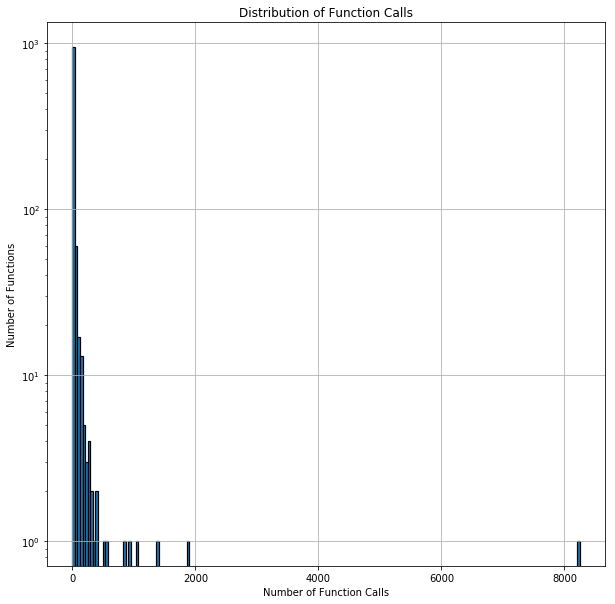

In [38]:
# See the entire dataset
plt.figure(figsize=(10,10))
plt.hist(countsList, 200, log=True, edgecolor='black', linewidth=1.2)
plt.title("Distribution of Function Calls")
plt.xlabel("Number of Function Calls")
plt.ylabel("Number of Functions")
plt.grid()
plt.show()

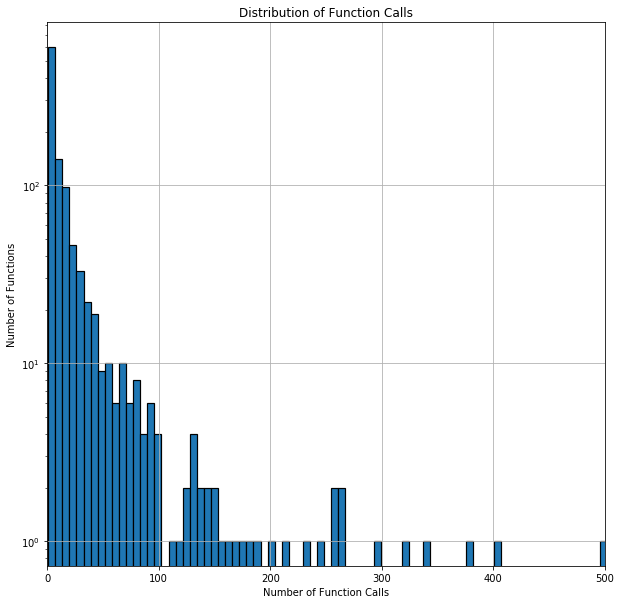

In [37]:
# Ignoring Outliers 
plt.figure(figsize=(10,10))
plt.xlim(0, 500)
plt.hist(countsList, 1300, log=True, edgecolor='black', linewidth=1.2)
plt.title("Distribution of Function Calls")
plt.xlabel("Number of Function Calls")
plt.ylabel("Number of Functions")
plt.grid()
plt.show()

# Data Analysis

We would like to know the following: 
1. Is there a correlation between NPATH Complexity and Function Call Count?
2. Is there a correlation between Cyclomatic Complexity and Function Call Count?
3. Is there a correlation between Asymptotic Path Complexity and Function Call Count

First, load the NPATH/Cyclomatic Complexity/APC Data

In [13]:
import paths, os
apache_results = "/home/gabe/Documents/repos/path-complexity/" + \
                 "results/expected/apache_cfgs_all_expected_results.csv"
metrics = paths.MetricsCalculator.fromCSV(apache_results, None)

Create a dictionary mapping function names to (NPATH, Cyclomatic, APC, Function Call Count)

In [14]:
for i, result in enumerate(metrics.results): 
    func_name = os.path.basename(result[0])
    metrics.results[i] = [func_name] + result[1:]

In [18]:
for r in metrics.results: 
    print(r)

['org_apache_bcel_classfile_AccessFlags_getAccessFlags_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_classfile_AccessFlags_getModifiers_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_classfile_AccessFlags_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_classfile_AccessFlags_isAbstract_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_bcel_classfile_AccessFlags_isAnnotation_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_bcel_classfile_AccessFlags_isEnum_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_bcel_classfile_AccessFlags_isFinal_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_bcel_classfile_AccessFlags_isInterface_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_bcel_classfile_AccessFlags_isNative_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_bcel_classfile_AccessFlags_isPrivate_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_bc

['org_apache_bcel_generic_LDC_setIndex_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_generic_LDC_setSize_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_bcel_generic_LDC_W_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_generic_LDC_W_initFromFile_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_generic_LDIV_accept_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_generic_LDIV_getExceptions_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_generic_LDIV_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_generic_LineNumberGen_clone_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_bcel_generic_LineNumberGen_containsTarget_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_bcel_generic_LineNumberGen_getInstruction_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_generic_LineNumberGen_getLineNumber_0_basic.dot', 1.0, 1.0, 'Con

['org_apache_bcel_verifier_statics_StringRepresentation_visitDeprecated_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_verifier_statics_StringRepresentation_visitExceptionTable_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_verifier_statics_StringRepresentation_visitField_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_verifier_statics_StringRepresentation_visitInnerClass_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_verifier_statics_StringRepresentation_visitInnerClasses_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_verifier_statics_StringRepresentation_visitJavaClass_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_verifier_statics_StringRepresentation_visitLineNumber_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_verifier_statics_StringRepresentation_visitLineNumberTable_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_bcel_verifier_statics_

['org_apache_commons_beanutils_locale_LocaleBeanUtilsBean$Descriptor_getTarget_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_beanutils_locale_LocaleBeanUtilsBean$Descriptor_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_beanutils_locale_LocaleBeanUtilsBean$Descriptor_setIndex_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_beanutils_locale_LocaleBeanUtilsBean$Descriptor_setKey_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_beanutils_locale_LocaleBeanUtilsBean$Descriptor_setName_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_beanutils_locale_LocaleBeanUtilsBean$Descriptor_setPropName_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_beanutils_locale_LocaleBeanUtilsBean$Descriptor_setTarget_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_beanutils_locale_LocaleBeanUtils_calculate_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_

['org_apache_commons_codec_binary_Base64_decodeInteger_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_codec_binary_Base64_encode_0_basic.dot', 17.0, 43.0, 'Exponential', '1756.08*1.44^n', '33.86 + 0.01*0.9^n + 0.02*0.91^n + 13.870000000000001*1.18^n + 1756.08*1.44^n']
['org_apache_commons_codec_binary_Base64_encodeBase64_0_basic.dot', 5.0, 6.0, 'Constant', '6.', '6.']
['org_apache_commons_codec_binary_Base64_encodeBase64Chunked_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_codec_binary_Base64_encodeBase64String_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_codec_binary_Base64_encodeBase64URLSafe_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_codec_binary_Base64_encodeBase64URLSafeString_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_codec_binary_Base64_encodeInteger_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_codec_binary_Base64_<init>_0_basic.dot', 6

['org_apache_commons_collections4_bidimap_UnmodifiableOrderedBidiMap_values_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections4_bidimap_UnmodifiableSortedBidiMap_clear_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections4_bidimap_UnmodifiableSortedBidiMap_entrySet_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections4_bidimap_UnmodifiableSortedBidiMap_headMap_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections4_bidimap_UnmodifiableSortedBidiMap_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections4_bidimap_UnmodifiableSortedBidiMap_inverseBidiMap_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections4_bidimap_UnmodifiableSortedBidiMap_keySet_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections4_bidimap_UnmodifiableSortedBidiMap_mapIterator_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']


['org_apache_commons_collections4_map_AbstractReferenceMap$ReferenceMapIterator_setValue_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_collections4_map_AbstractReferenceMap$ReferenceStrength_<clinit>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections4_map_AbstractReferenceMap$ReferenceStrength_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections4_map_AbstractReferenceMap$ReferenceStrength_resolve_0_basic.dot', 4.0, 4.0, 'Constant', '4.', '4.']
['org_apache_commons_collections4_map_AbstractReferenceMap$ReferenceStrength_valueOf_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections4_map_AbstractReferenceMap$ReferenceStrength_values_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections4_map_AbstractReferenceMap$ReferenceValues_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections4_map_AbstractReferenceMap$ReferenceV

['org_apache_commons_collections4_trie_AbstractPatriciaTrie_incrementModCount_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections4_trie_AbstractPatriciaTrie_incrementSize_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections4_trie_AbstractPatriciaTrie_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections4_trie_AbstractPatriciaTrie_isValidUplink_0_basic.dot', 4.0, 4.0, 'Constant', '4.', '4.']
['org_apache_commons_collections4_trie_AbstractPatriciaTrie_keySet_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_collections4_trie_AbstractPatriciaTrie_lastEntry_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections4_trie_AbstractPatriciaTrie_lastKey_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_collections4_trie_AbstractPatriciaTrie_lowerEntry_0_basic.dot', 6.0, 6.0, 'Constant', '6.', '6.']
['org_apache_commons_collections4_trie_Abstract

['org_apache_commons_compress_archivers_zip_ZipEightByteInteger_equals_0_basic.dot', 3.0, 3.0, 'Constant', '3.', '3.']
['org_apache_commons_compress_archivers_zip_ZipEightByteInteger_getBytes_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_compress_archivers_zip_ZipEightByteInteger_getLongValue_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_compress_archivers_zip_ZipEightByteInteger_getValue_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_compress_archivers_zip_ZipEightByteInteger_hashCode_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_compress_archivers_zip_ZipEightByteInteger_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_compress_archivers_zip_ZipEightByteInteger_toString_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_compress_archivers_zip_ZipEncodingHelper_appendSurrogate_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_compre

['org_apache_commons_configuration_interpol_ConstantLookup_<clinit>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_configuration_interpol_ConstantLookup_fetchClass_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_configuration_interpol_ConstantLookup_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_configuration_interpol_ConstantLookup_lookup_0_basic.dot', 8.0, 8.0, 'Constant', '8.', '8.']
['org_apache_commons_configuration_interpol_ConstantLookup_resolveField_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_configuration_interpol_EnvironmentLookup_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_configuration_interpol_EnvironmentLookup_lookup_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_configuration_interpol_ExprLookup_createContext_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_configuration_interpol_ExprLookup_getVariables

['org_apache_commons_csv_Lexer_readEscape_0_basic.dot', 9.0, 9.0, 'Constant', '9.', '9.']
['org_apache_commons_csv_Lexer_trimTrailingSpaces_0_basic.dot', 4.0, 6.0, 'Polynomial', '1.33*n', '5.71 + 1.33*n']
['org_apache_commons_csv_QuoteMode_<clinit>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_csv_QuoteMode_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_csv_QuoteMode_valueOf_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_csv_QuoteMode_values_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_csv_Token_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_csv_Token_reset_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_csv_Token_toString_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_csv_Token$Type_<clinit>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_csv_Token$Type_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '

['org_apache_commons_dbcp2_managed_ManagedConnection_commit_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_dbcp2_managed_ManagedConnection_getDelegate_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_dbcp2_managed_ManagedConnection_getInnermostDelegate_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_dbcp2_managed_ManagedConnection_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_dbcp2_managed_ManagedConnection_isAccessToUnderlyingConnectionAllowed_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_dbcp2_managed_ManagedConnection_rollback_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_dbcp2_managed_ManagedConnection_setAutoCommit_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_dbcp2_managed_ManagedConnection_setReadOnly_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_dbcp2_managed_ManagedConnection_transactionComplete

['org_apache_commons_digester3_xmlrules_SetPropertyRule_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_digester3_xmlrules_SetRootRule_bindRule_0_basic.dot', 3.0, 3.0, 'Constant', '3.', '3.']
['org_apache_commons_digester3_xmlrules_SetRootRule_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_digester3_xmlrules_SetTopRule_bindRule_0_basic.dot', 3.0, 3.0, 'Constant', '3.', '3.']
['org_apache_commons_digester3_xmlrules_SetTopRule_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_digester3_xmlrules_WithMemoryRulesBinder_addError_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_digester3_xmlrules_WithMemoryRulesBinder_forPattern_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_digester3_xmlrules_WithMemoryRulesBinder_getContextClassLoader_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_digester3_xmlrules_WithMemoryRulesBinder_getIncludedFiles_0_basic.

['org_apache_commons_digester3_Digester_getDocumentLocator_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_digester3_Digester_getEntityResolver_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_digester3_Digester_getErrorHandler_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_digester3_Digester_getExecutorService_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_digester3_Digester_getFactory_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_digester3_Digester_getFeature_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_digester3_Digester_getLogger_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_digester3_Digester_getMatch_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_digester3_Digester_getMatches_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_digester3_Digester_getNamespaceAware_0_basic.dot', 1.0, 1.0, 'C

['org_apache_commons_discovery_jdk_PsuedoSystemClassLoader_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_discovery_jdk_PsuedoSystemClassLoader_loadClass_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_discovery_log_DiscoveryLogFactory_<clinit>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_discovery_log_DiscoveryLogFactory_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_discovery_log_DiscoveryLogFactory__newLog_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_discovery_log_DiscoveryLogFactory_newLog_0_basic.dot', 4.0, 4.0, 'Constant', '4.', '4.']
['org_apache_commons_discovery_log_DiscoveryLogFactory_setFactory_0_basic.dot', 6.0, 6.0, 'Exponential', '4.3500000000000005*1.22^n', '2. + 0.01*0.72^n + 0.51*1.06^n + 4.3500000000000005*1.22^n']
['org_apache_commons_discovery_log_DiscoveryLogFactory_setLog_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons

['org_apache_commons_io_filefilter_FileFilterUtils_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_io_filefilter_FileFilterUtils_magicNumberFileFilter_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_io_filefilter_FileFilterUtils_makeCVSAware_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_io_filefilter_FileFilterUtils_makeDirectoryOnly_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_io_filefilter_FileFilterUtils_makeFileOnly_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_io_filefilter_FileFilterUtils_makeSVNAware_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_io_filefilter_FileFilterUtils_nameFileFilter_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_io_filefilter_FileFilterUtils_notFileFilter_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_io_filefilter_FileFilterUtils_or_0_basic.dot', 1.0, 1.0, 'Constant', '1.

['org_apache_commons_jexl2_internal_DuckSetExecutor_discover_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_jexl2_internal_DuckSetExecutor_execute_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_jexl2_internal_DuckSetExecutor_getTargetProperty_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_jexl2_internal_DuckSetExecutor_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_jexl2_internal_DuckSetExecutor_tryExecute_0_basic.dot', 7.0, 7.0, 'Constant', '7.', '7.']
['org_apache_commons_jexl2_internal_EnumerationIterator_hasNext_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_jexl2_internal_EnumerationIterator_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_jexl2_internal_EnumerationIterator_next_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_jexl2_internal_EnumerationIterator_remove_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['or

['org_apache_commons_jxpath_ri_EvalContext_toString_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_jxpath_ri_InfoSetUtil_booleanValue_0_basic.dot', 13.0, 13.0, 'Constant', '13.', '13.']
['org_apache_commons_jxpath_ri_InfoSetUtil_<clinit>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_jxpath_ri_InfoSetUtil_doubleValue_0_basic.dot', 10.0, 10.0, 'Constant', '10.', '10.']
['org_apache_commons_jxpath_ri_InfoSetUtil_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_jxpath_ri_InfoSetUtil_number_0_basic.dot', 9.0, 9.0, 'Constant', '9.', '9.']
['org_apache_commons_jxpath_ri_InfoSetUtil_stringValue_0_basic.dot', 10.0, 10.0, 'Constant', '10.', '10.']
['org_apache_commons_jxpath_ri_JXPathCompiledExpression_createPath_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_jxpath_ri_JXPathCompiledExpression_createPathAndSetValue_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_jxpath_ri_JXPathComp

['org_apache_commons_jxpath_util_TypeUtils_canConvert_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_jxpath_util_TypeUtils_class$_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_jxpath_util_TypeUtils_<clinit>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_jxpath_util_TypeUtils_convert_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_jxpath_util_TypeUtils_getTypeConverter_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_jxpath_util_TypeUtils_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_jxpath_util_TypeUtils_setTypeConverter_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_jxpath_util_TypeUtils_wrapPrimitive_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_jxpath_util_TypeUtils$1_<init>_0_basic.dot', 9.0, 256.0, 'Constant', '256.', '256.']
['org_apache_commons_jxpath_util_ValueUtils_class$_0_basic.dot', 2.0, 2.0, '

['org_apache_commons_lang3_text_translate_NumericEntityUnescaper_isSet_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_lang3_text_translate_NumericEntityUnescaper_translate_0_basic.dot', 24.0, 4902.0, 'Exponential', '523819.10000000003*1.3900000000000001^n', '456.2 + 0.01*0.73^n + 10.06*1.01^n + 1776.33*1.16^n + 523819.10000000003*1.3900000000000001^n']
['org_apache_commons_lang3_text_translate_NumericEntityUnescaper$OPTION_<clinit>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_lang3_text_translate_NumericEntityUnescaper$OPTION_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_lang3_text_translate_NumericEntityUnescaper$OPTION_valueOf_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_lang3_text_translate_NumericEntityUnescaper$OPTION_values_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_lang3_text_translate_OctalUnescaper_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']


['org_apache_commons_math3_analysis_solvers_LaguerreSolver$ComplexSolver_solve_0_basic.dot', 8.0, 6.0, 'Exponential', '35.230000000000004*1.29^n', '1.5 + 0.48*1.09^n + 0.32*1.11^n + 4.29*1.16^n + 0.85*1.24^n + 35.230000000000004*1.29^n']
['org_apache_commons_math3_analysis_solvers_LaguerreSolver$ComplexSolver_solveAll_0_basic.dot', 6.0, 8.0, 'Exponential', '10.21*1.62^(0.5*n)', '1. + 0.03*0.62^(0.5*n) + 10.21*1.62^(0.5*n)']
['org_apache_commons_math3_analysis_solvers_MullerSolver2_doSolve_0_basic.dot', 11.0, 37.0, 'Exponential', '208.72*1.4000000000000001^n', '3. + 0.33*0.93^n + 0.14*0.98^n + 0.16*1.04^n + 2.96*1.08^n + 2.21*1.22^n + 208.72*1.4000000000000001^n']
['org_apache_commons_math3_analysis_solvers_MullerSolver2_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_analysis_solvers_MullerSolver_doSolve_0_basic.dot', 5.0, 5.0, 'Constant', '5.', '5.']
['org_apache_commons_math3_analysis_solvers_MullerSolver_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1

['org_apache_commons_math3_geometry_euclidean_threed_SubLine_intersection_0_basic.dot', 7.0, 7.0, 'Constant', '7.', '7.']
['org_apache_commons_math3_geometry_euclidean_threed_SubPlane_buildNew_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_geometry_euclidean_threed_SubPlane_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_geometry_euclidean_threed_SubPlane_side_0_basic.dot', 5.0, 5.0, 'Constant', '5.', '5.']
['org_apache_commons_math3_geometry_euclidean_threed_SubPlane_split_0_basic.dot', 6.0, 10.0, 'Constant', '10.', '10.']
['org_apache_commons_math3_geometry_euclidean_threed_Vector3D_add_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_geometry_euclidean_threed_Vector3D_angle_0_basic.dot', 5.0, 6.0, 'Constant', '6.', '6.']
['org_apache_commons_math3_geometry_euclidean_threed_Vector3D_<clinit>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_geometry_euclidean_threed_Vector

['org_apache_commons_math3_ml_neuralnet_Network$NeuronIdentifierComparator_compare_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_ml_neuralnet_Network$NeuronIdentifierComparator_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_ml_neuralnet_Network$SerializationProxy_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_ml_neuralnet_Network$SerializationProxy_readResolve_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_ml_neuralnet_Neuron_compareAndSetFeatures_0_basic.dot', 4.0, 4.0, 'Constant', '4.', '4.']
['org_apache_commons_math3_ml_neuralnet_Neuron_containSameValues_0_basic.dot', 4.0, 4.0, 'Polynomial', '0.67*n', '5.05 + 0.67*n']
['org_apache_commons_math3_ml_neuralnet_Neuron_getFeatures_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_ml_neuralnet_Neuron_getIdentifier_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_

['org_apache_commons_math3_optim_nonlinear_scalar_noderiv_AbstractSimplex_getPoint_0_basic.dot', 3.0, 3.0, 'Constant', '3.', '3.']
['org_apache_commons_math3_optim_nonlinear_scalar_noderiv_AbstractSimplex_getPoints_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_optim_nonlinear_scalar_noderiv_AbstractSimplex_getSize_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_optim_nonlinear_scalar_noderiv_AbstractSimplex_<init>_0_basic.dot', 10.0, 18.0, 'Exponential', '108.29*1.34^n', '1.57 + 0.04*0.98^n + 0.87*1.02^n + 1.59*1.1300000000000001^n + 0.37*1.17^n + 108.29*1.34^n']
['org_apache_commons_math3_optim_nonlinear_scalar_noderiv_AbstractSimplex_replaceWorstPoint_0_basic.dot', 3.0, 3.0, 'Exponential', '2.92*1.22^n', '1. + 0.02*0.72^n + 0.45*1.06^n + 2.92*1.22^n']
['org_apache_commons_math3_optim_nonlinear_scalar_noderiv_AbstractSimplex_setPoint_0_basic.dot', 3.0, 3.0, 'Constant', '3.', '3.']
['org_apache_commons_math3_optim_nonlinear_scalar

['org_apache_commons_math3_stat_descriptive_SynchronizedMultivariateSummaryStatistics_clear_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_stat_descriptive_SynchronizedMultivariateSummaryStatistics_equals_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_stat_descriptive_SynchronizedMultivariateSummaryStatistics_getCovariance_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_stat_descriptive_SynchronizedMultivariateSummaryStatistics_getDimension_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_stat_descriptive_SynchronizedMultivariateSummaryStatistics_getGeoMeanImpl_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_stat_descriptive_SynchronizedMultivariateSummaryStatistics_getGeometricMean_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_math3_stat_descriptive_SynchronizedMultivariateSummaryStatistics_getMax_0_basic.dot', 1.0, 1.0, 'Consta

['org_apache_commons_net_nntp_NewGroupsOrNewsQuery_getNewsgroups_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_net_nntp_NewGroupsOrNewsQuery_getTime_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_net_nntp_NewGroupsOrNewsQuery_<init>_0_basic.dot', 12.0, 486.0, 'Constant', '486.', '486.']
['org_apache_commons_net_nntp_NewGroupsOrNewsQuery_isGMT_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_net_nntp_NewGroupsOrNewsQuery_omitNewsgroup_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_net_nntp_NewsgroupInfo_getArticleCount_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_net_nntp_NewsgroupInfo_getArticleCountLong_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_net_nntp_NewsgroupInfo_getFirstArticle_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_net_nntp_NewsgroupInfo_getFirstArticleLong_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apa

['org_apache_commons_pool2_impl_GenericObjectPoolConfig_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_pool2_impl_GenericObjectPoolConfig_setMaxIdle_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_pool2_impl_GenericObjectPoolConfig_setMaxTotal_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_pool2_impl_GenericObjectPoolConfig_setMinIdle_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_pool2_impl_GenericObjectPool_create_0_basic.dot', 7.0, 10.0, 'Constant', '10.', '10.']
['org_apache_commons_pool2_impl_GenericObjectPool_destroy_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_pool2_impl_GenericObjectPool_ensureIdle_0_basic.dot', 9.0, 19.0, 'Exponential', '33.09*2.^(0.2*n)', '5. + 2.1*1.1500000000000001^n + 33.09*2.^(0.2*n)']
['org_apache_commons_pool2_impl_GenericObjectPool_ensureMinIdle_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_pool2_impl_GenericObjec

['org_apache_commons_collections_primitives_decorators_BaseUnmodifiableIntList_retainAll_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections_primitives_decorators_BaseUnmodifiableIntList_set_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections_primitives_decorators_BaseUnmodifiableIntList_subList_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections_primitives_decorators_BaseUnmodifiableLongList_add_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections_primitives_decorators_BaseUnmodifiableLongList_addAll_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections_primitives_decorators_BaseUnmodifiableLongList_clear_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections_primitives_decorators_BaseUnmodifiableLongList_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_collections_primitives_decorators_BaseUn

['org_apache_commons_validator_routines_ShortValidator_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_validator_routines_ShortValidator_isInRange_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_validator_routines_ShortValidator_maxValue_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_validator_routines_ShortValidator_minValue_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_validator_routines_ShortValidator_processParsedValue_0_basic.dot', 3.0, 3.0, 'Constant', '3.', '3.']
['org_apache_commons_validator_routines_ShortValidator_validate_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_validator_routines_TimeValidator_<clinit>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_validator_routines_TimeValidator_compareHours_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_validator_routines_TimeValidator_compareMinutes_0_basic.dot', 1.0, 1.0, 

['org_apache_commons_weaver_model_ScanResult$3$1_read_0_basic.dot', 3.0, 3.0, 'Polynomial', '0.67*n', '3.38 + 0.67*n']
['org_apache_commons_weaver_model_ScanResult$3$1_remove_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_weaver_model_ScanResult$4_childrenOf_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_weaver_model_ScanResult$4_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_weaver_model_ScanResult$5_childrenOf_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_weaver_model_ScanResult$5_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_weaver_model_ScanResult$6_childrenOf_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_weaver_model_ScanResult$6_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_weaver_model_ScanResult$7_childrenOf_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_weaver_model_ScanResult$7_

['org_apache_tools_ant_PropertyHelper_setProperty_0_basic.dot', 12.0, 32.0, 'Polynomial', '5.33*n', '75.38 + 5.33*n']
['org_apache_tools_ant_PropertyHelper_setPropertyHook_0_basic.dot', 3.0, 3.0, 'Constant', '3.', '3.']
['org_apache_tools_ant_PropertyHelper_setUserProperty_0_basic.dot', 3.0, 3.0, 'Constant', '3.', '3.']
['org_apache_tools_ant_PropertyHelper_testIfCondition_0_basic.dot', 3.0, 3.0, 'Constant', '3.', '3.']
['org_apache_tools_ant_PropertyHelper_testUnlessCondition_0_basic.dot', 3.0, 3.0, 'Constant', '3.', '3.']
['org_apache_tools_ant_PropertyHelper_toBoolean_0_basic.dot', 7.0, 7.0, 'Constant', '7.', '7.']
['org_apache_tools_ant_PropertyHelper$1_evaluate_0_basic.dot', 4.0, 6.0, 'Constant', '6.', '6.']
['org_apache_tools_ant_PropertyHelper$1_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_tools_ant_PropertyHelper$2_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_tools_ant_PropertyHelper$2_parsePropertyName_0_basic.dot', 6.0, 6.0, 'Cons

['org_apache_tools_ant_types_selectors_ContainsSelector_setEncoding_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_tools_ant_types_selectors_ContainsSelector_setIgnorewhitespace_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_tools_ant_types_selectors_ContainsSelector_setParameters_0_basic.dot', 6.0, 6.0, 'Exponential', '7.21*1.31^n', '0.8200000000000001 + 0.28*1.1400000000000001^n + 1.11*1.16^n + 7.21*1.31^n']
['org_apache_tools_ant_types_selectors_ContainsSelector_setText_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_tools_ant_types_selectors_ContainsSelector_toString_0_basic.dot', 3.0, 4.0, 'Constant', '4.', '4.']
['org_apache_tools_ant_types_selectors_ContainsSelector_verifySettings_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_tools_ant_types_selectors_DateSelector_<clinit>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_tools_ant_types_selectors_DateSelector_getMillis_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '

['org_apache_commons_weaver_normalizer__asm_commons_LocalVariablesSorter_updateNewLocals_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_weaver_normalizer__asm_commons_LocalVariablesSorter_visitFrame_0_basic.dot', 17.0, 134.0, 'Exponential', '14133.720000000001*1.4000000000000001^n', '2.52 + 0.02*0.98^n + 0.02*0.99^n + 22.13*1.1500000000000001^n + 5.0600000000000005*1.17^n + 12.01*1.19^n + 160.93*1.22^n + 4376.57*1.34^n + 14133.720000000001*1.4000000000000001^n + 0.02*n']
['org_apache_commons_weaver_normalizer__asm_commons_LocalVariablesSorter_visitIincInsn_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_weaver_normalizer__asm_commons_LocalVariablesSorter_visitLocalVariable_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_weaver_normalizer__asm_commons_LocalVariablesSorter_visitMaxs_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_weaver_normalizer__asm_commons_LocalVariablesSorter_visitVarInsn_0_basic.do

['org_apache_commons_weaver_privilizer__asm_tree_FieldNode_class$_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_weaver_privilizer__asm_tree_FieldNode_<clinit>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_weaver_privilizer__asm_tree_FieldNode_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_weaver_privilizer__asm_tree_FieldNode_visitAnnotation_0_basic.dot', 4.0, 4.0, 'Constant', '4.', '4.']
['org_apache_commons_weaver_privilizer__asm_tree_FieldNode_visitAttribute_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_commons_weaver_privilizer__asm_tree_FieldNode_visitEnd_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_commons_weaver_privilizer__asm_tree_FieldNode_visitTypeAnnotation_0_basic.dot', 4.0, 4.0, 'Constant', '4.', '4.']
['org_apache_commons_weaver_privilizer__asm_tree_FrameNode_accept_0_basic.dot', 6.0, 6.0, 'Constant', '6.', '6.']
['org_apache_commons_weaver_privilizer__asm_tree_Frame

['org_apache_sanselan_color_ColorHunterLab_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_sanselan_color_ColorHunterLab_toString_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_sanselan_color_ColorXYZ_<init>_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_sanselan_color_ColorXYZ_toString_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_sanselan_ColorTools_convertBetweenColorSpaces_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_sanselan_ColorTools_convertBetweenColorSpacesX2_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_sanselan_ColorTools_convertBetweenICCProfiles_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_sanselan_ColorTools_convertFromColorSpace_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_sanselan_ColorTools_convertToColorSpace_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_sanselan_ColorTools_convertToICCProfile_0_basic.dot', 1.0, 1.0, 'Constant', 

['org_apache_sanselan_formats_tiff_TiffImageParser_getDefaultExtension_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_sanselan_formats_tiff_TiffImageParser_getFormatCompliance_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_sanselan_formats_tiff_TiffImageParser_getICCProfileBytes_0_basic.dot', 2.0, 2.0, 'Constant', '2.', '2.']
['org_apache_sanselan_formats_tiff_TiffImageParser_getImageInfo_0_basic.dot', 25.0, 12962.0, 'Polynomial', '3240.*n', '60428. + 3240.*n']
['org_apache_sanselan_formats_tiff_TiffImageParser_getImageSize_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_sanselan_formats_tiff_TiffImageParser_getMetadata_0_basic.dot', 3.0, 3.0, 'Exponential', '1.8900000000000001*1.62^(0.5*n)', '0. + 0.17*0.62^(0.5*n) + 1.8900000000000001*1.62^(0.5*n)']
['org_apache_sanselan_formats_tiff_TiffImageParser_getName_0_basic.dot', 1.0, 1.0, 'Constant', '1.', '1.']
['org_apache_sanselan_formats_tiff_TiffImageParser_getPhotometricInterpreter_0_basic.dot',